# 1 Environment Setup

## 1.1 Dependent Packages

In [105]:
! pip install pandas python-docx
! pip install seaborn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   -------------------------------------- - 286.7/294.9 kB 8.6 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 6.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pickle

import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

## 1.2 Load All Data

In [2]:
with open('./Data/Array_data/NO2_open_interp.pkl', 'rb') as f:
    NO2_open_interp = pickle.load(f)

with open('./Data/Array_data/Y_mean_std_dict.pkl', 'rb') as f:
    Y_mean_std_dict = pickle.load(f)

Stations_NO2 = gpd.read_file("./Data/Stations_NO2.geojson")

NO2_data = pd.read_csv('./Data/NO2_data.csv')

# 2 Temporal Data Analysis

## 2.1 Basic Analysis

In [113]:
def calculate_summary_statistics(df, exclude_column=None):
    # Exclude specified column from the calculations if provided
    if exclude_column:
        df = df.drop(columns=exclude_column)
    
    # Calculate summary statistics
    summary_stats = {
        'Min': df.min().min(),
        'Max': df.max().max(),
        'Mean': df.mean().mean(),
        'Range': df.max().max() - df.min().min(),
        'Standard Deviation': df.stack().std()
    }

    # Convert summary statistics to a DataFrame for better presentation
    summary_stats_df = pd.DataFrame(summary_stats, index=[0])

    print(summary_stats_df)

    return summary_stats_df

NO2_open_interp_stats = calculate_summary_statistics(NO2_open_interp)

   Min    Max       Mean  Range  Standard Deviation
0 -2.4  235.7  26.684617  238.1           17.780371


In [114]:
# Replace negative values with 0
NO2_open_interp.iloc[:, 1:] = NO2_open_interp.iloc[:, 1:].clip(lower=0)
NO2_open_interp_stats = calculate_summary_statistics(NO2_open_interp)

with open('./Data/Array_data/NO2_open_interp.pkl', 'wb') as f:
    pickle.dump(NO2_open_interp, f)

   Min    Max       Mean  Range  Standard Deviation
0  0.0  235.7  26.684868  235.7           17.779985


In [115]:
NO2_interp_array = NO2_open_interp.iloc[:, 1:].values

# Find all indices where the maximum and minimum value 0 occurs
max_indices = np.where(NO2_interp_array == NO2_interp_array.max())
min_indices = np.where(NO2_interp_array == NO2_interp_array.min())
# Convert the indices to a list of tuples
max_indices_list = list(zip(max_indices[0], max_indices[1]))
min_indices_list = list(zip(min_indices[0], min_indices[1]))
# Using list comprehension to find the Site_code for each extreme value index
max_site_codes = [NO2_open_interp.index[idx[0]] for idx in max_indices_list]
min_site_codes = [NO2_open_interp.index[idx[0]] for idx in min_indices_list]

# Using list comprehension to find the timestamp for each maximum index
max_timestamps =[NO2_open_interp.columns[idx[1]] for idx in max_indices_list]
min_timestamps =[NO2_open_interp.columns[idx[1]] for idx in min_indices_list]

print("The stations and corresponding timestamps with maximum NO2 value", f"Total number is {len(max_site_codes)}")
for spatial_max in zip(max_site_codes, max_timestamps):
    print(spatial_max)

print("The stations and corresponding timestamps with minimum NO2 value", f"Total number is {len(min_site_codes)}")
for spatial_min in zip(min_site_codes, min_timestamps):
    print(spatial_min)

The stations and corresponding timestamps with maximum NO2 value Total number is 1
('BT4', Timestamp('2023-05-04 11:00:00'))
The stations and corresponding timestamps with minimum NO2 value Total number is 178
('BY7', Timestamp('2023-01-04 00:00:00'))
('BY7', Timestamp('2023-01-04 01:00:00'))
('BY7', Timestamp('2023-01-04 02:00:00'))
('BY7', Timestamp('2023-01-06 00:00:00'))
('BY7', Timestamp('2023-01-13 01:00:00'))
('BY7', Timestamp('2023-01-13 02:00:00'))
('BY7', Timestamp('2023-01-13 03:00:00'))
('BY7', Timestamp('2023-01-15 03:00:00'))
('EN4', Timestamp('2023-01-04 01:00:00'))
('EN4', Timestamp('2023-01-12 01:00:00'))
('EN4', Timestamp('2023-01-12 02:00:00'))
('EN4', Timestamp('2023-01-12 03:00:00'))
('EN4', Timestamp('2023-01-13 02:00:00'))
('GN0', Timestamp('2023-03-31 02:00:00'))
('GN3', Timestamp('2023-12-28 00:00:00'))
('GN3', Timestamp('2023-12-28 02:00:00'))
('GN3', Timestamp('2023-12-31 00:00:00'))
('GN4', Timestamp('2023-01-04 00:00:00'))
('GN4', Timestamp('2023-01-04 01:0

In [71]:
NO2_CE3_missing = NO2_data.loc[(NO2_data["Site_code"] == "CE3")]  
NO2_CE3_missing = NO2_CE3_missing.reset_index(drop=True)
NO2_CE3_missing = NO2_CE3_missing.set_index('Site_code') 
NO2_CE3_missing_T = NO2_CE3_missing.T
NO2_CE3_missing_T = NO2_CE3_missing_T.rename(columns={"CE3": "CE3_ori"})
NO2_CE3_missing_T.index = pd.to_datetime(NO2_CE3_missing_T.index)

NO2_CE3_interp = NO2_open_interp.loc[(NO2_open_interp.index == "CE3")]
NO2_CE3_interp_T = NO2_CE3_interp.T
NO2_CE3_interp_T
NO2_CE3_interp_T = NO2_CE3_interp_T.rename(columns={"CE3": "CE3_interp"})

NO2_CE3_compare = pd.concat([NO2_CE3_interp_T, NO2_CE3_missing_T], axis=1)
NO2_CE3_compare

Site_code,CE3_interp,CE3_ori
2023-01-01 00:00:00,49.7,NaN
2023-01-01 01:00:00,49.7,NaN
2023-01-01 02:00:00,49.7,NaN
2023-01-01 03:00:00,49.7,NaN
2023-01-01 04:00:00,49.7,NaN
...,...,...
2023-12-31 19:00:00,22.6,22.6
2023-12-31 20:00:00,23.7,23.7
2023-12-31 21:00:00,22.8,22.8
2023-12-31 22:00:00,21.1,21.1


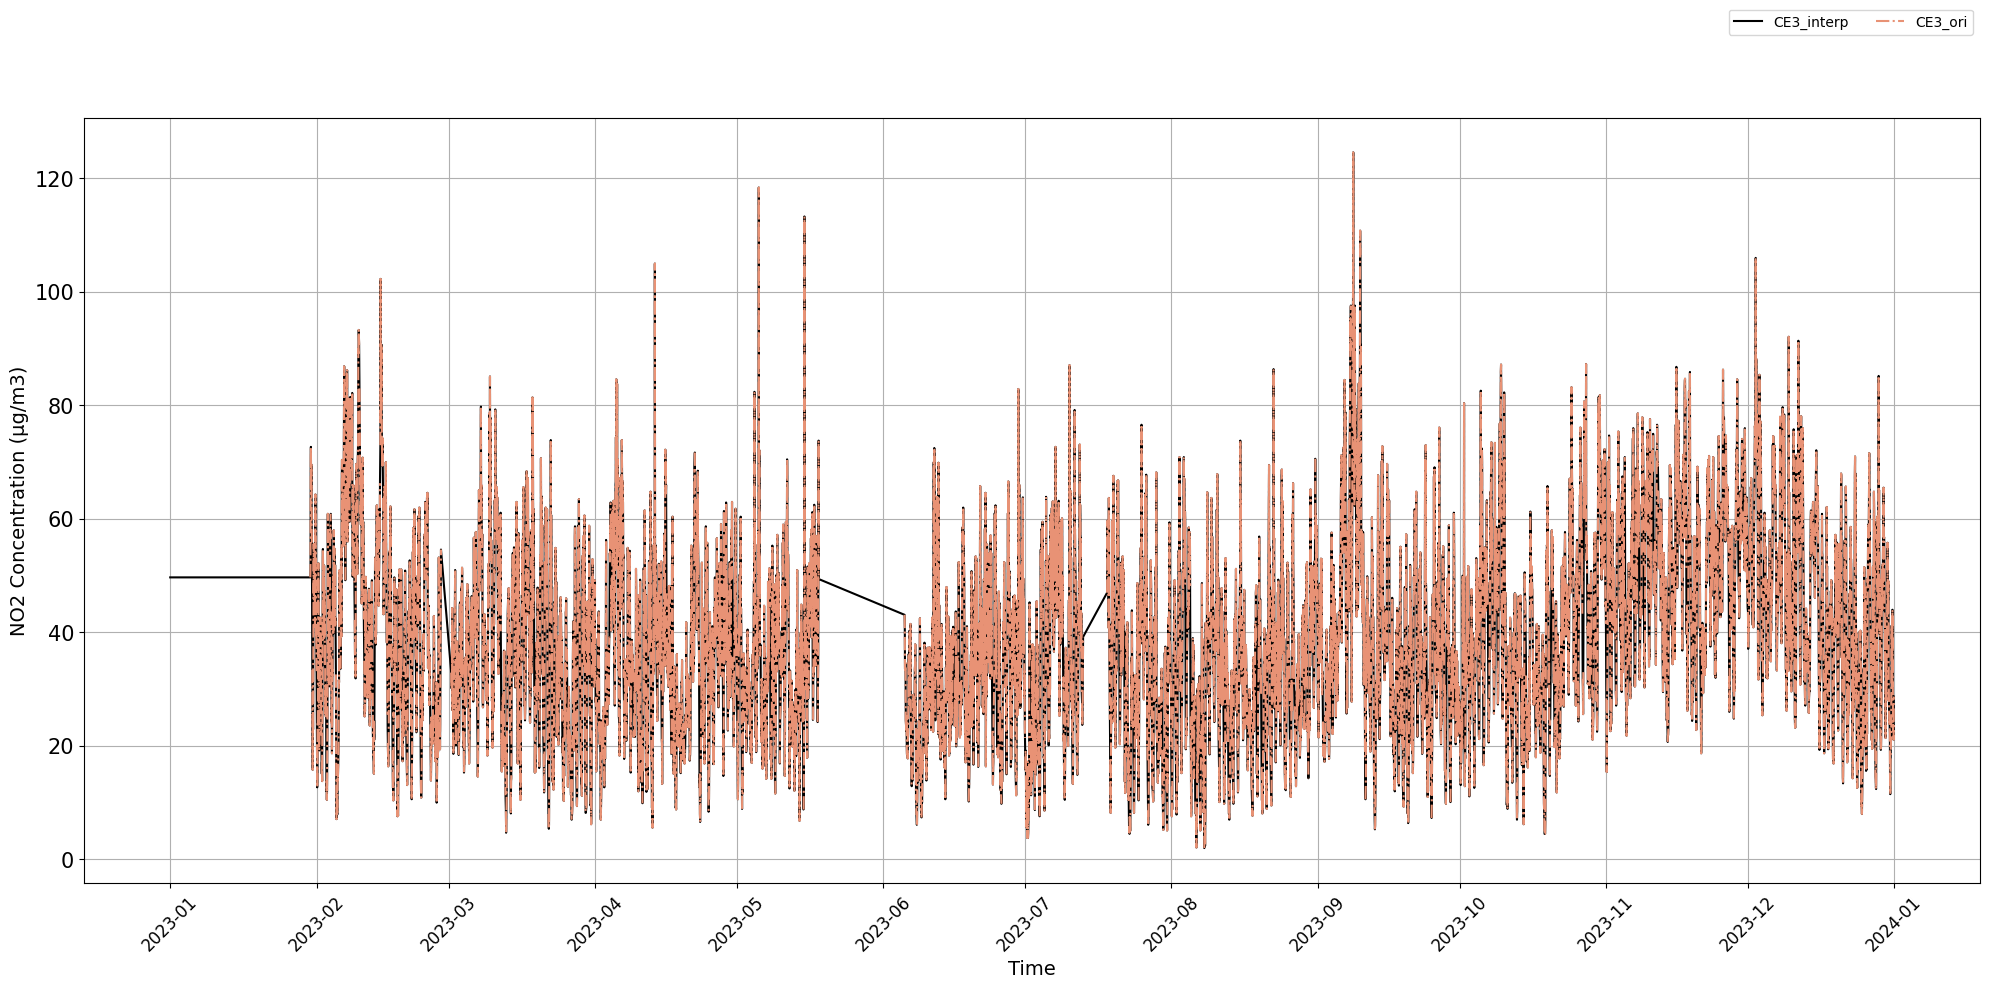

In [72]:
# Plotting the line chart
plt.figure(figsize=(20, 10))
for idx, station in enumerate(NO2_CE3_compare.columns):
    if station == "CE3_ori":
        plt.plot(NO2_CE3_compare.index, NO2_CE3_compare[station], label=station, linestyle='-.', color="#e89275", alpha=1)
    else:
        plt.plot(NO2_CE3_compare.index, NO2_CE3_compare[station], label=station, color="black")

# Adjusting tick parameters for x and y axis to increase font size
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)

# Setting the labels and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('NO2 Concentration (μg/m3)', fontsize=14)
# Generate a date range for the x-axis (assuming hourly data for one year)
date_range = pd.date_range(start='2023-01-01', periods=len(NO2_open_interp), freq='h')
# Format the x-axis to show every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'YYYY-MM'

# Adjusting the legend to be horizontally aligned at the top of the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=5)  # Horizontal Alignment, first for left-right, second for bottom-top (0-1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a PNG file
# plt.savefig('./Figures/Time_series_Stats/NO2_CE3_interp.png', format='png', dpi=300)

# Displaying the plot
plt.show()

In [73]:
NO2_KT4_missing = NO2_data.loc[(NO2_data["Site_code"] == "KT4")]  
NO2_KT4_missing = NO2_KT4_missing.reset_index(drop=True)
NO2_KT4_missing = NO2_KT4_missing.set_index('Site_code') 
NO2_KT4_missing_T = NO2_KT4_missing.T
NO2_KT4_missing_T = NO2_KT4_missing_T.rename(columns={"KT4": "KT4_ori"})
NO2_KT4_missing_T.index = pd.to_datetime(NO2_KT4_missing_T.index)

NO2_KT4_interp = NO2_open_interp.loc[(NO2_open_interp.index == "KT4")]
NO2_KT4_interp_T = NO2_KT4_interp.T
NO2_KT4_interp_T
NO2_KT4_interp_T = NO2_KT4_interp_T.rename(columns={"KT4": "KT4_interp"})

NO2_KT4_compare = pd.concat([NO2_KT4_interp_T, NO2_KT4_missing_T], axis=1)
NO2_KT4_compare

Site_code,KT4_interp,KT4_ori
2023-01-01 00:00:00,17.0,NaN
2023-01-01 01:00:00,17.0,NaN
2023-01-01 02:00:00,17.0,NaN
2023-01-01 03:00:00,17.0,NaN
2023-01-01 04:00:00,17.0,NaN
...,...,...
2023-12-31 19:00:00,20.3,20.3
2023-12-31 20:00:00,13.6,13.6
2023-12-31 21:00:00,11.9,11.9
2023-12-31 22:00:00,11.1,11.1


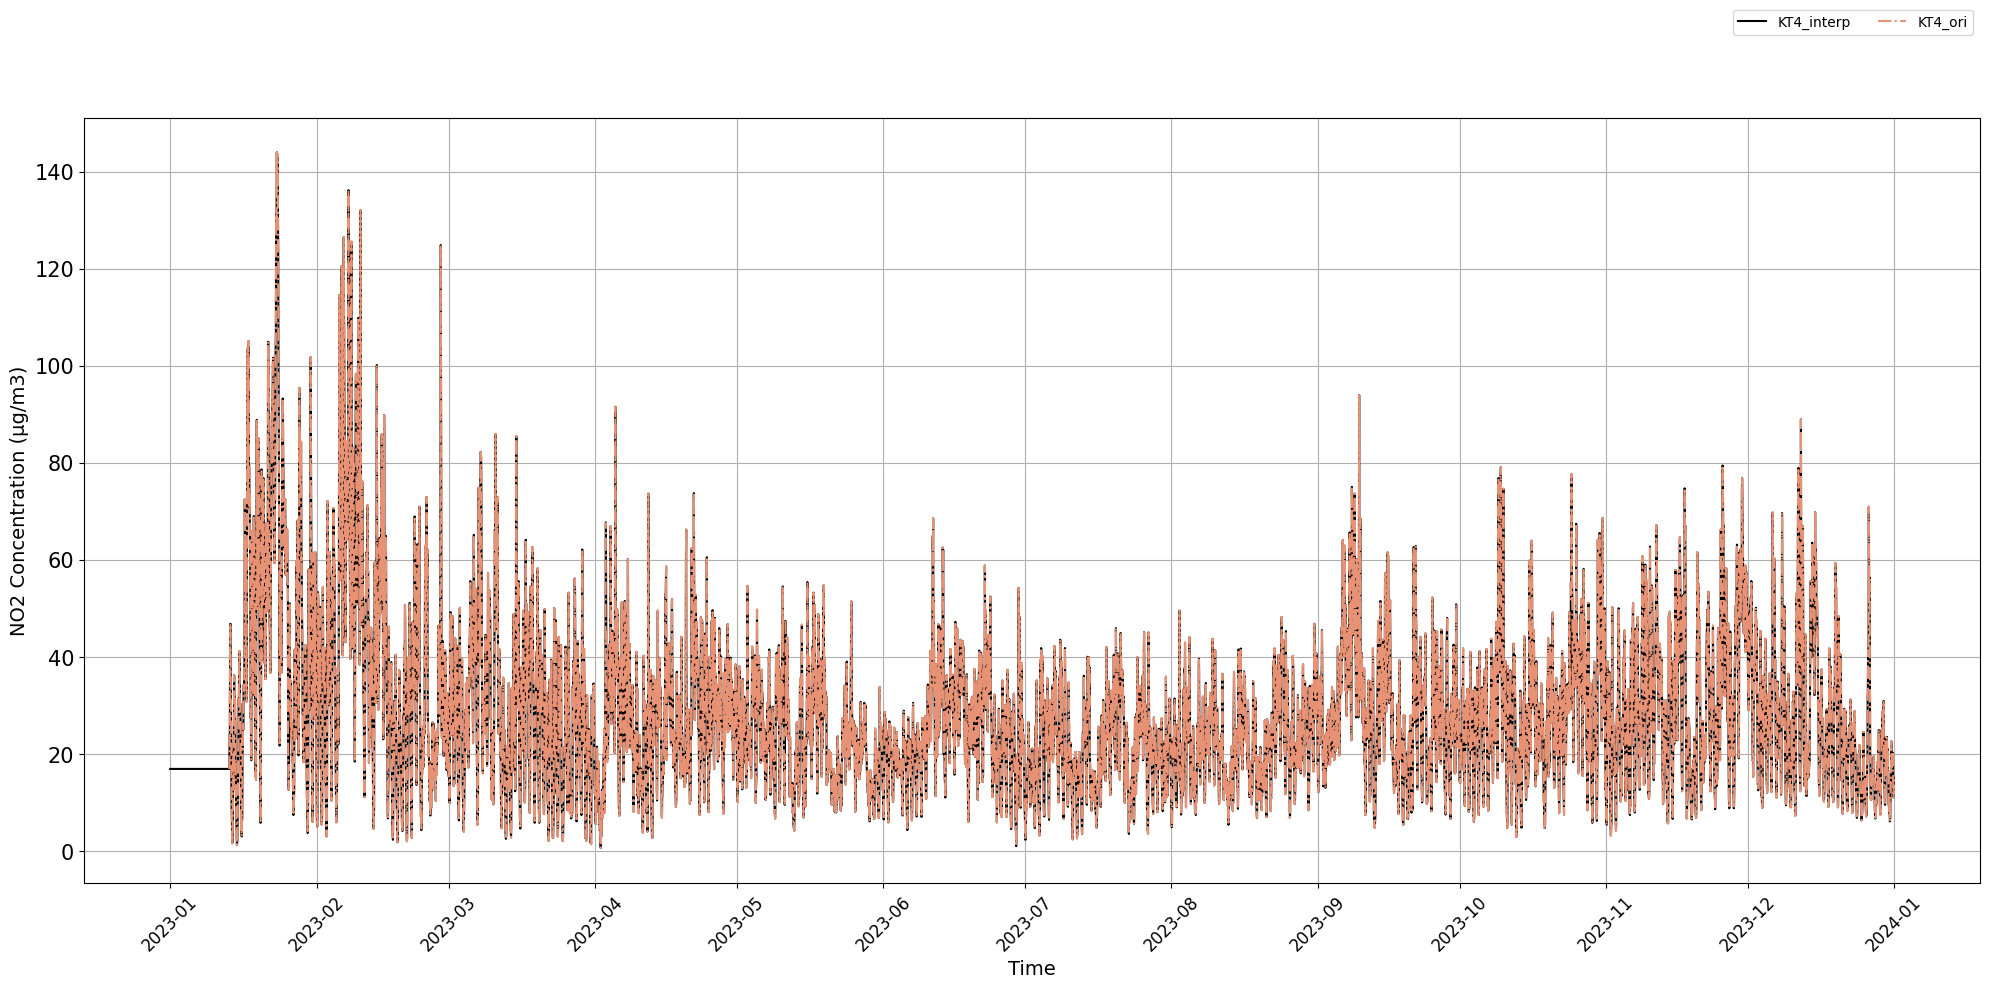

In [70]:
# Plotting the line chart
plt.figure(figsize=(20, 10))
for idx, station in enumerate(NO2_KT4_compare.columns):
    if station == "KT4_ori":
        plt.plot(NO2_KT4_compare.index, NO2_KT4_compare[station], label=station, linestyle='-.', color="#e89275", alpha=1)
    else:
        plt.plot(NO2_KT4_compare.index, NO2_KT4_compare[station], label=station, color="black")

# Adjusting tick parameters for x and y axis to increase font size
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)

# Setting the labels and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('NO2 Concentration (μg/m3)', fontsize=14)
# Generate a date range for the x-axis (assuming hourly data for one year)
date_range = pd.date_range(start='2023-01-01', periods=len(NO2_open_interp), freq='h')
# Format the x-axis to show every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'YYYY-MM'

# Adjusting the legend to be horizontally aligned at the top of the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=5)  # Horizontal Alignment, first for left-right, second for bottom-top (0-1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a PNG file
# plt.savefig('./Figures/Time_series_Stats/NO2_KT4_interp.png', format='png', dpi=300)

# Displaying the plot
plt.show()

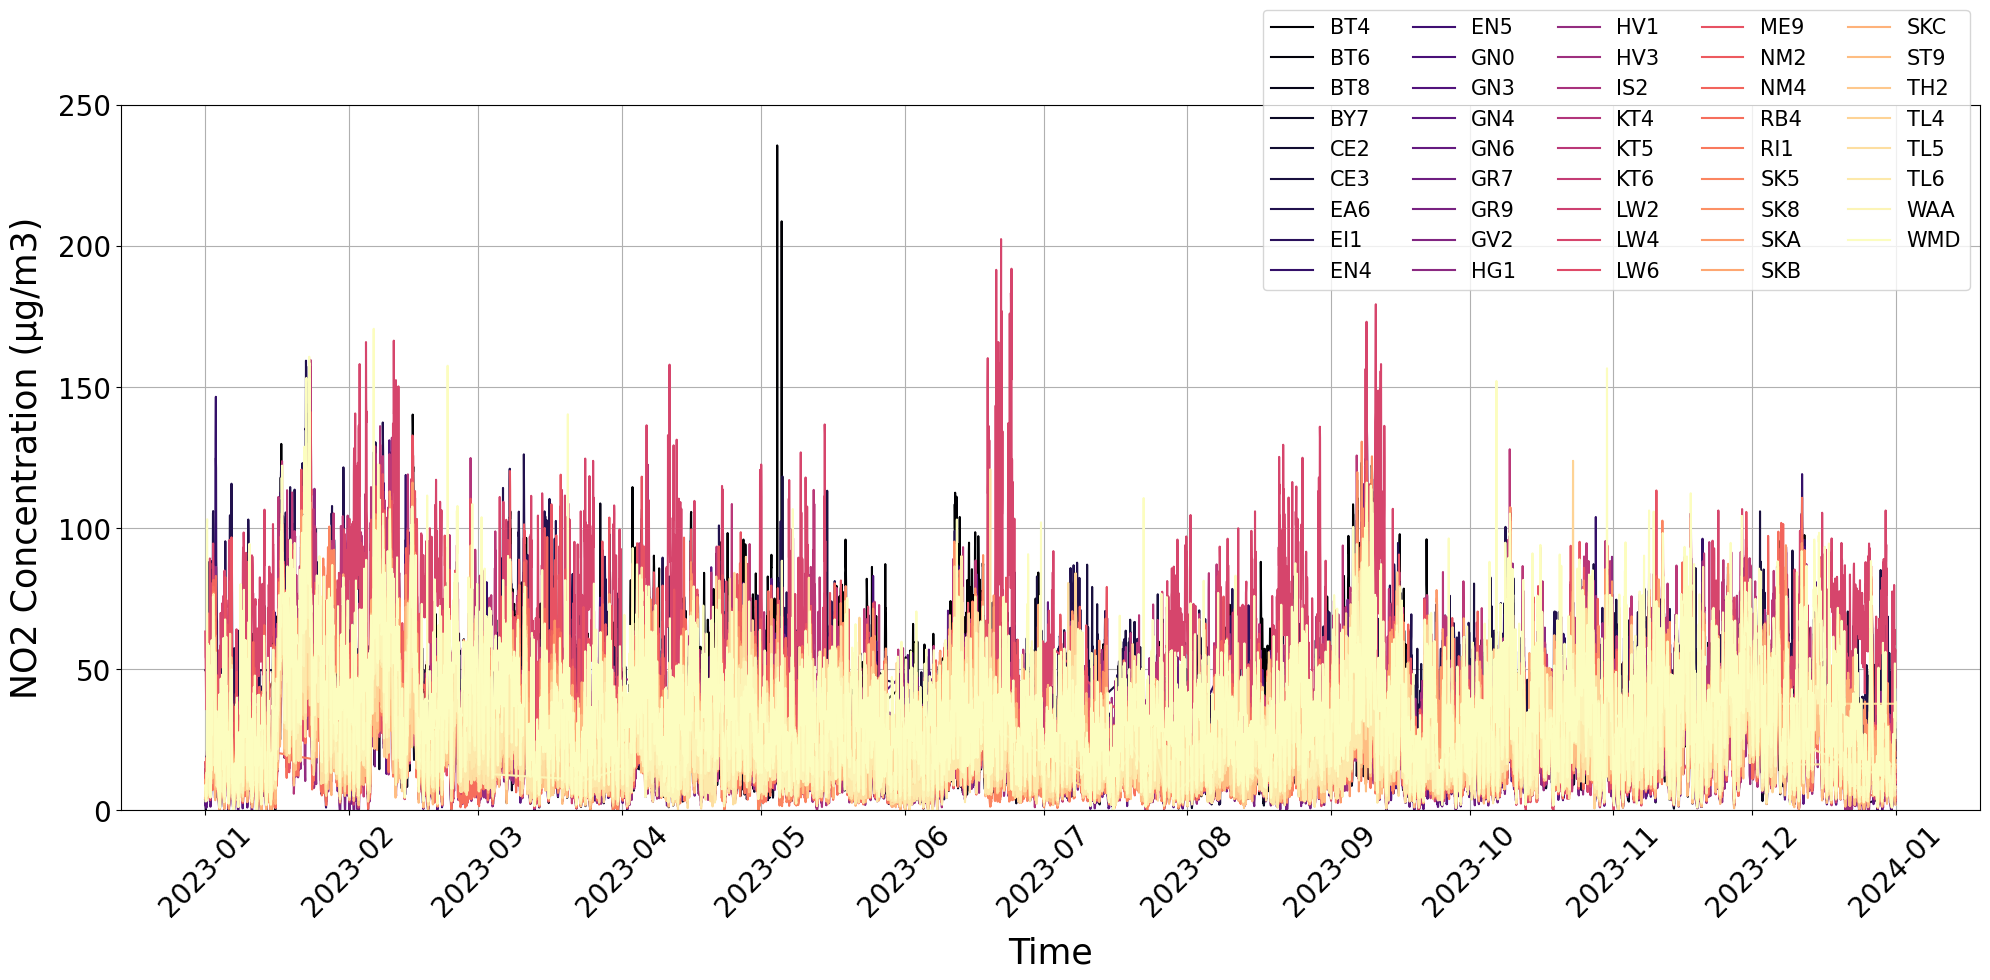

In [13]:
NO2_transposed = NO2_open_interp.T
# Create a color map
cmap = plt.get_cmap('magma')  # viridis_r, inferno, magma
colors = cmap(np.linspace(0, 1, NO2_transposed.shape[1]))

# Plotting the line chart
plt.figure(figsize=(20, 10))
for idx, station in enumerate(NO2_transposed.columns):
    plt.plot(NO2_transposed.index, NO2_transposed[station], label=station, color=colors[idx])

# Adjusting tick parameters for x and y axis to increase font size
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

# Setting the labels and title
plt.xlabel('Time', fontsize=25, labelpad=10)
plt.ylabel('NO2 Concentration (μg/m3)', fontsize=25, labelpad=10)
# Generate a date range for the x-axis (assuming hourly data for one year)
date_range = pd.date_range(start='2023-01-01', periods=len(NO2_open_interp), freq='h')
# Format the x-axis to show every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'YYYY-MM'

# Adjusting the legend to be horizontally aligned at the top of the plot
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=5, fontsize=15)  # Horizontal Alignment, first for left-right, second for bottom-top (0-1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Set y-axis range
plt.ylim(0, 250)
# Save the plot as a PNG file
plt.savefig('./Figures/Time_series_Stats/Hourly_NO2_all_stations.png', format='png', dpi=300)

# Displaying the plot
plt.show()

C:\Users\Becky\AppData\Local\Temp\ipykernel_11876\643495174.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2023-01-01', periods=len(avg_stations_NO2), freq='H')


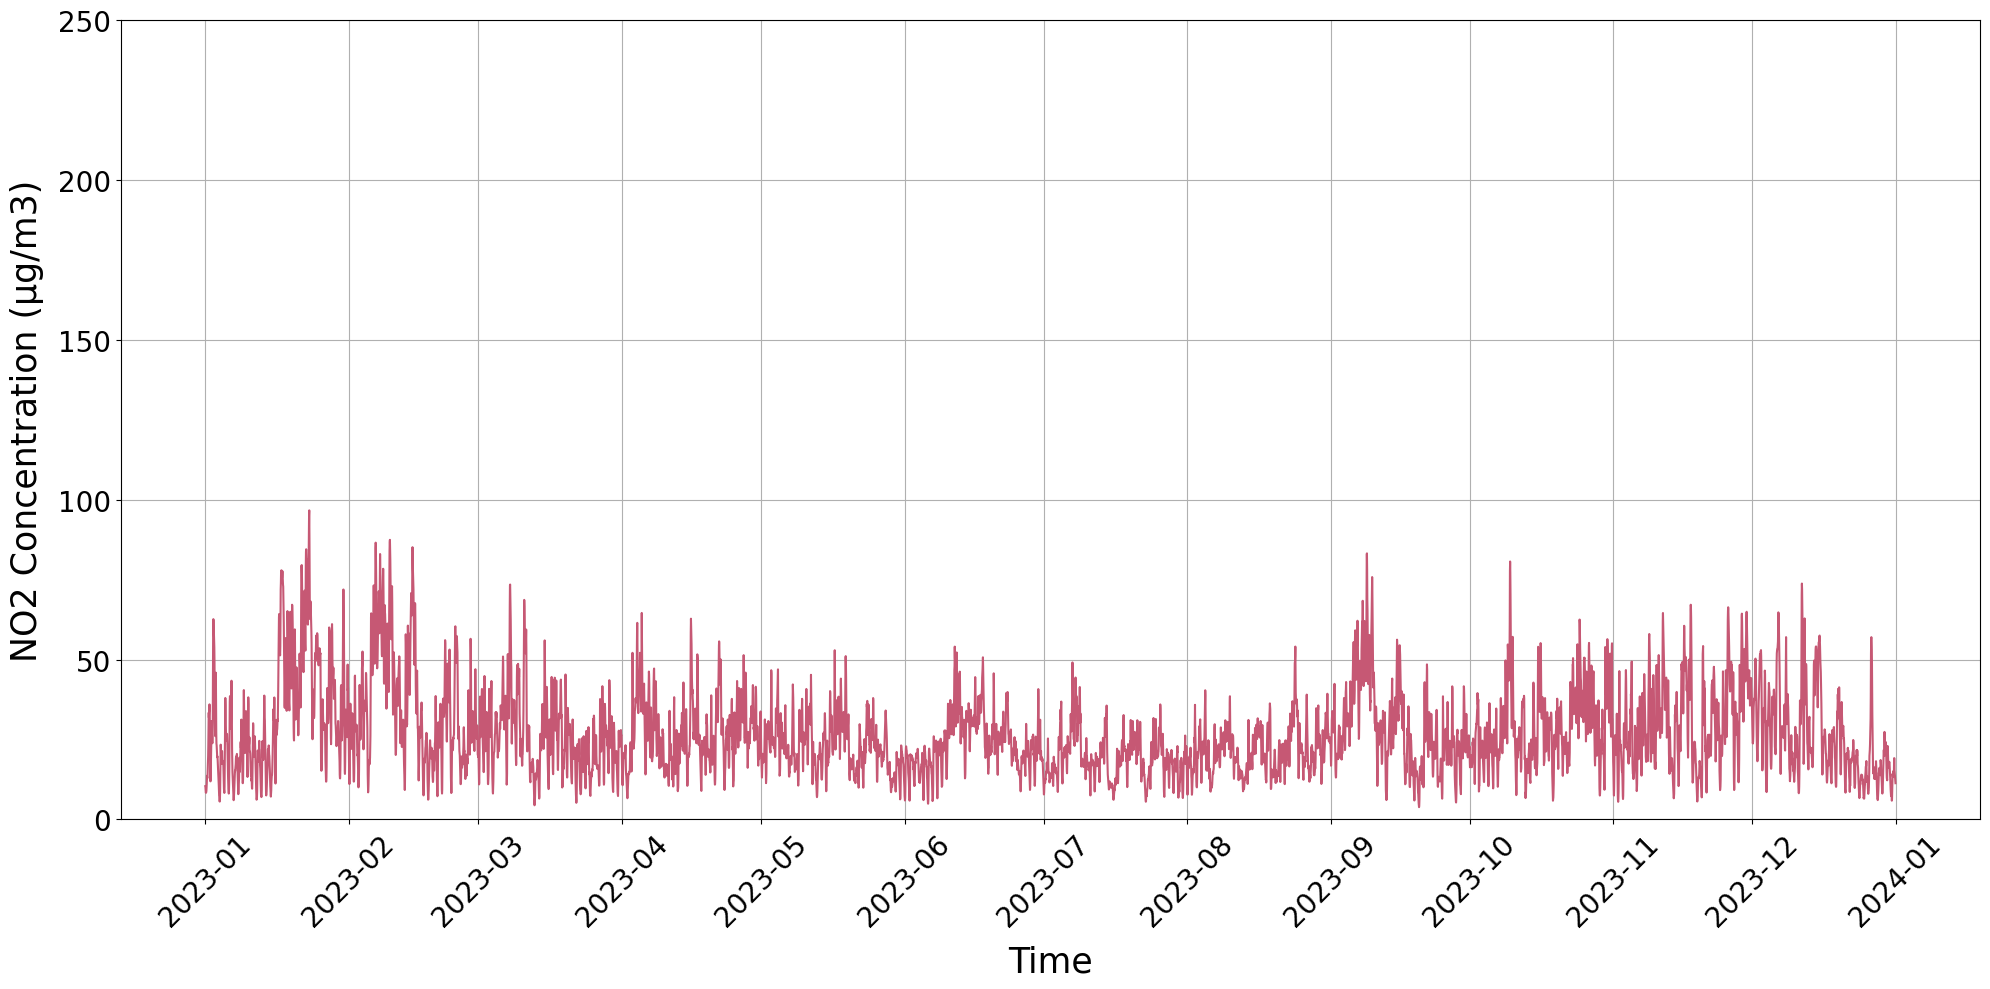

In [14]:
import matplotlib.dates as mdates
avg_stations_NO2 = NO2_open_interp.mean()

# Plotting the line chart
plt.figure(figsize=(20, 10))
plt.plot(avg_stations_NO2.index, avg_stations_NO2.values, color = '#c65874') # '#1f316f'

# Adjusting tick parameters for x and y axis to increase font size
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

# Setting the labels and title
plt.xlabel('Time', fontsize=25, labelpad=10)
plt.ylabel('NO2 Concentration (μg/m3)', fontsize=25, labelpad=10)

# Generate a date range for the x-axis (assuming hourly data for one year)
date_range = pd.date_range(start='2023-01-01', periods=len(avg_stations_NO2), freq='H')
# Format the x-axis to show every month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format ticks as 'YYYY-MM'

# Set y-axis range
plt.ylim(0, 250)

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

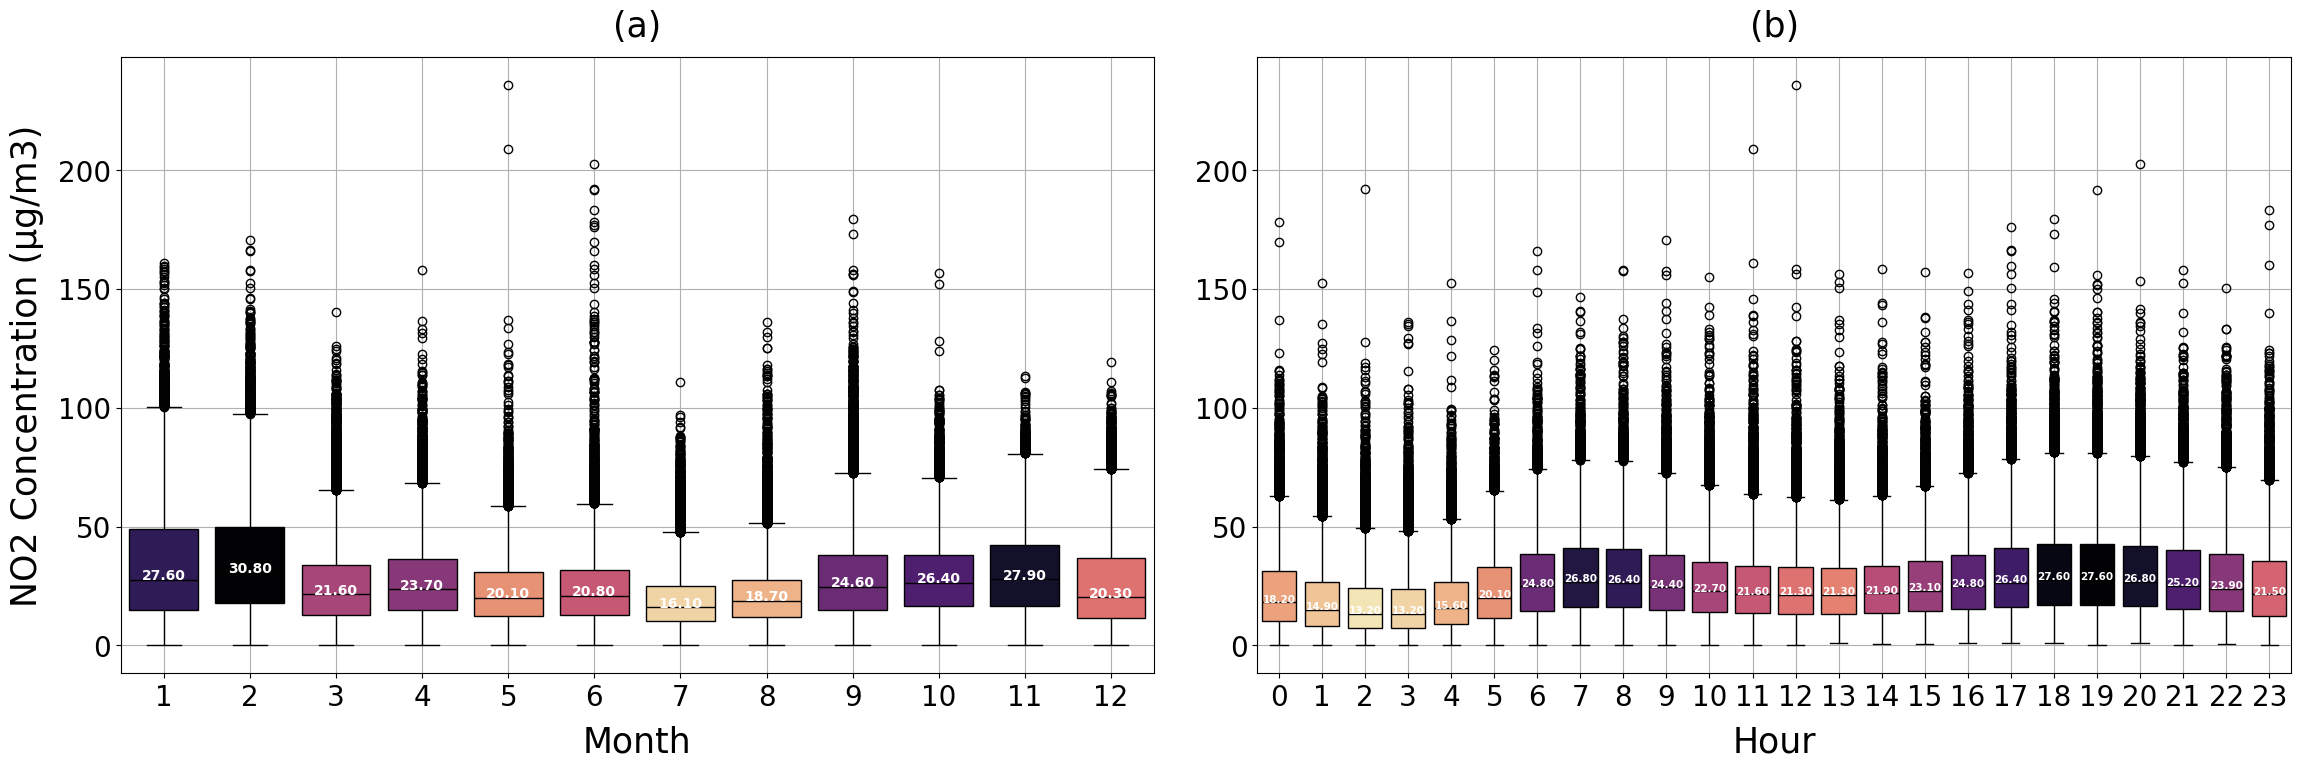

In [18]:
# Function to create a custom palette
def create_custom_palette(medians):
    sorted_median = medians.sort_values(ascending=False)
    sorted_months = sorted_median.index
    cmap = sns.color_palette("magma", as_cmap=True)
    custom_palette = [cmap(i / len(sorted_months)) for i in range(len(sorted_months))]
    return {month: color for month, color in zip(sorted_months, custom_palette)}

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(28, 8), gridspec_kw={'wspace': 0.1}) # Adjust wspace to change the space between plots

NO2_transposed = NO2_open_interp.T
# Reset the index to convert the transposed index to a column
NO2_transposed.reset_index(inplace=True)
# Rename the column
NO2_transposed.rename(columns={'index': 'Datetime'}, inplace=True)

# Plot for Month
NO2_transposed['Month'] = NO2_transposed['Datetime'].dt.month
NO2_melted_month = NO2_transposed.melt(id_vars=['Datetime', 'Month'], var_name='Site', value_name='NO2')
medians_month = NO2_melted_month.groupby('Month')['NO2'].median()
palette_dict_month = create_custom_palette(medians_month)

sns.boxplot(x='Month', y='NO2', data=NO2_melted_month, hue='Month', palette=palette_dict_month, ax=axes[0])
for i, median in enumerate(medians_month):
    axes[0].text(i, median, f'{median:.2f}', horizontalalignment='center', color='white', weight='semibold')
axes[0].set_title('(a)', fontsize=25, pad=15)
axes[0].set_xlabel('Month', fontsize=25, labelpad=10)
axes[0].set_ylabel('NO2 Concentration (μg/m3)', fontsize=25, labelpad=10)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].grid(True)
axes[0].get_legend().remove()  # Remove legend

# Plot for Hour
NO2_transposed['Hour'] = NO2_transposed['Datetime'].dt.hour
NO2_melted_hour = NO2_transposed.melt(id_vars=['Datetime', 'Hour'], var_name='Station', value_name='NO2')
medians_hour = NO2_melted_hour.groupby('Hour')['NO2'].median()
palette_dict_hour = create_custom_palette(medians_hour)

sns.boxplot(x='Hour', y='NO2', data=NO2_melted_hour, hue='Hour', palette=palette_dict_hour, ax=axes[1])
for i, median in enumerate(medians_hour):
    axes[1].text(i, median, f'{median:.2f}', horizontalalignment='center', color='white', weight='semibold', fontsize = 7.5)
axes[1].set_title('(b)', fontsize=25, pad=15)
axes[1].set_xlabel('Hour', fontsize=25, labelpad=10)
# axes[1].set_ylabel('NO2 Concentration (μg/m3)', fontsize=12)
axes[1].set_ylabel('', labelpad=0)  # Hide y-axis label
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].grid(True)
axes[1].get_legend().remove()  # Remove legend
# plt.tight_layout()

plt.savefig('./Figures/Time_series_Stats/Hour_Month_Boxplot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## 2.2 Time Series Correlation

In [22]:
from math import radians, sin, cos, sqrt, atan2
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return distance

# Extract latitude and longitude coordinates of the stations
coords = np.array([point.coords[0] for point in Stations_NO2.geometry])
# Calculate the distance matrix between stations
num_stations = len(Stations_NO2)
dist_matrix = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(i + 1, num_stations):
        dist = haversine(coords[i][1], coords[i][0], coords[j][1], coords[j][0])
        dist_matrix[i, j] = dist
        dist_matrix[j, i] = dist
dist_matrix

array([[ 0.        ,  1.78055515,  3.57421417, ..., 20.02096218,
        11.43328867, 10.18825374],
       [ 1.78055515,  0.        ,  2.16486928, ..., 18.94768538,
         9.79456248,  8.61331684],
       [ 3.57421417,  2.16486928,  0.        , ..., 16.79098777,
         7.8933858 ,  6.61899075],
       ...,
       [20.02096218, 18.94768538, 16.79098777, ...,  0.        ,
        11.56406721, 11.67957972],
       [11.43328867,  9.79456248,  7.8933858 , ..., 11.56406721,
         0.        ,  1.47126401],
       [10.18825374,  8.61331684,  6.61899075, ..., 11.67957972,
         1.47126401,  0.        ]])

Pearson correlation coefficient: -0.11


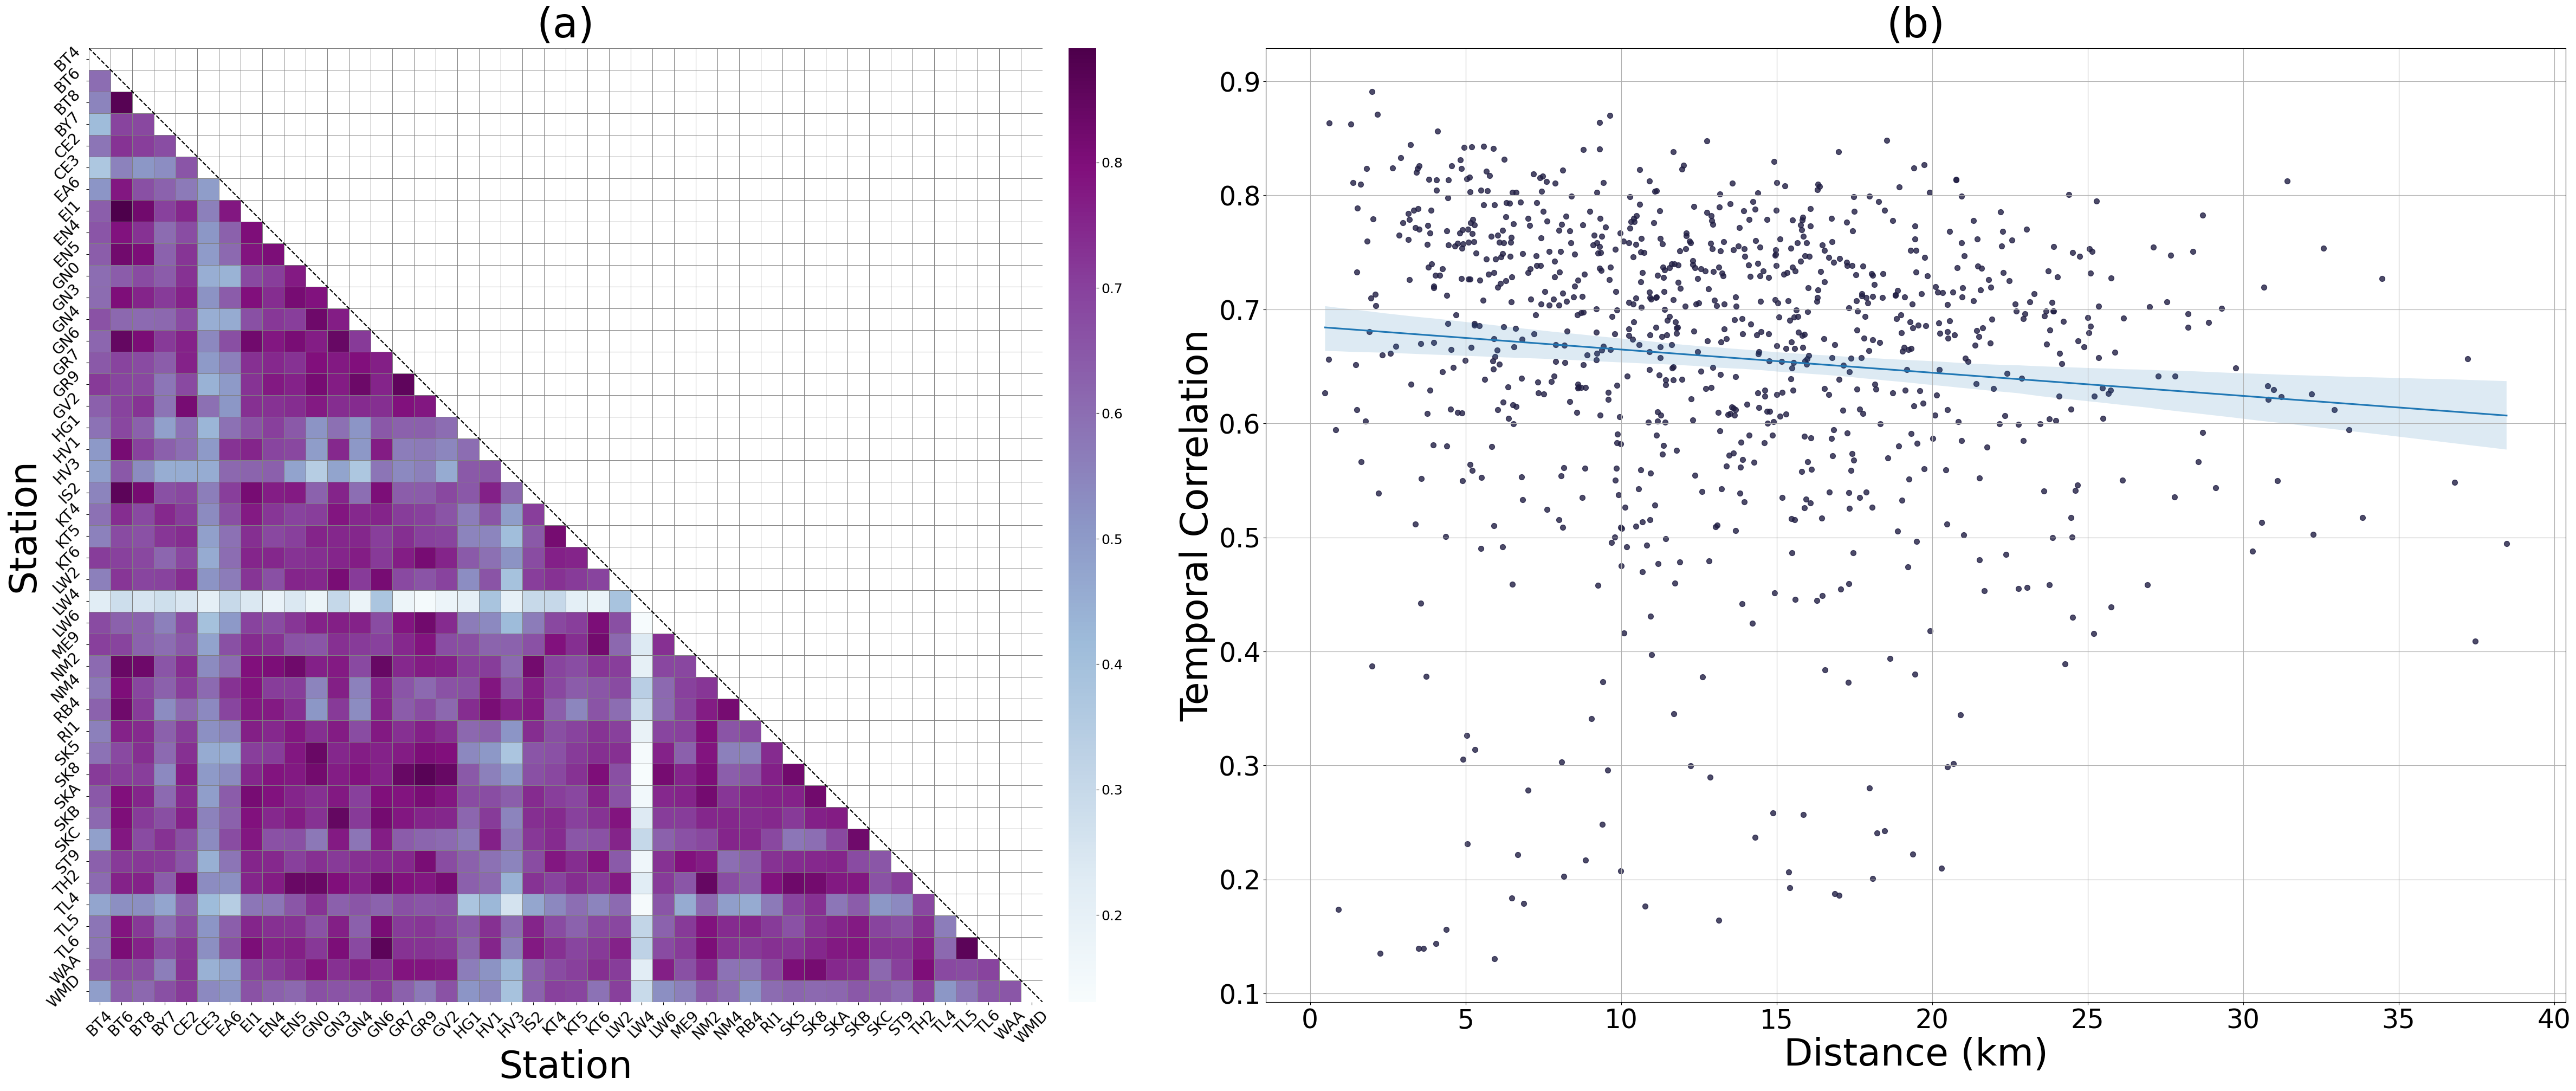

In [37]:
from scipy.stats import pearsonr

# Calculate the correlation matrix
correlation_df = NO2_open_interp.T.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_df, dtype=bool))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(50, 20))

# Heatmap
for i in range(len(correlation_df)):
    correlation_df.iat[i, i] = np.nan

heatmap = sns.heatmap(correlation_df, mask=mask, annot=False, cmap='BuPu', linewidths=.5, # magma_r YlGnBu
                    linecolor='grey', cbar_kws={"shrink": 1, "aspect": 35, "pad": 0.02}, ax=axes[0])
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

axes[0].plot([0, correlation_df.shape[0]], [0, correlation_df.shape[0]], 'k--', linewidth=1.5)
axes[0].set_title('(a)', fontsize=55, pad=15)
axes[0].set_xlabel('Station', fontsize=50)
axes[0].set_ylabel('Station', fontsize=50)
axes[0].tick_params(axis='x', rotation=45, labelsize=20)
axes[0].tick_params(axis='y', rotation=45, labelsize=20)
axes[0].set_aspect('equal')  # To keep the heatmap square

# Correlation and Distance Scatter Plot
correlation_matrix = correlation_df.values
temp_correlation = (correlation_matrix + correlation_matrix.T) / 2
np.fill_diagonal(temp_correlation, np.nan)

distance = (dist_matrix + dist_matrix.T) / 2
np.fill_diagonal(distance, np.nan)

upper_tri_indices = np.triu_indices(len(Stations_NO2), k=1)
correlation_values = temp_correlation[upper_tri_indices]
distance_values = distance[upper_tri_indices]

pearson_corr, _ = pearsonr(distance_values, correlation_values)
print(f"Pearson correlation coefficient: {pearson_corr:.2f}")

sns.regplot(x=distance_values, y=correlation_values, scatter_kws={'alpha': 0.8, 'color': '#201E43', 's': 50}, ax=axes[1])
axes[1].set_title('(b)', fontsize=55, pad=15)
axes[1].set_xlabel('Distance (km)', fontsize=50)
axes[1].set_ylabel('Temporal Correlation', fontsize=50)
axes[1].tick_params(axis='x', labelsize=35)
axes[1].tick_params(axis='y', labelsize=35)
axes[1].grid(True)

plt.tight_layout()

# Save the plot as a PNG file with reduced white space
plt.savefig('./Figures/Time_series_Stats/Timeseries_Correlation_And_Scatter.png', format='png', dpi=300, bbox_inches='tight')
plt.show()
